In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
#import keras

In [3]:
# Lectura del dataset
dataset_name = 'ds_salaries'
df = pd.read_csv(f'data/{dataset_name}.csv')

### Observant el dataset

In [4]:
# Visualitzem el dataset
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [5]:
# Atributs
atributs = df.dtypes

# Valors que poden prendre les variables object
atributs_object = df.select_dtypes(include=['object']).columns
string = ""
valors_diferentes = {} # Amb aquest diccionari convertirem les variables no numeriques a categoriques amb one hot enconding
for atribut in atributs_object:
    valors_diferentes[atribut] = df[atribut].nunique()
    string += f"{atribut}, "

# Resultats
print(f"Número d'atributs: {df.shape[1]}")
print(f"Número de files: {df.shape[0]}")
print("\nAtributs:")
print(atributs)
print(f"\nAtributs no numérics: \n{string}")

Número d'atributs: 11
Número de files: 3755

Atributs:
work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

Atributs no numérics: 
experience_level, employment_type, job_title, salary_currency, employee_residence, company_location, company_size, 


Como vemos tenemos 3 variables relacionadas con el salario: 'salary', 'salary_currency', 'salary_in_usd'. Para que tenga más sentido vamos a eliminar tanto 'salary' como 'salary_currency' y vamos a trabajar con 'salary_in_usd'.

In [6]:
#att_to_delete = ['salary','salary_currency']
df = df.drop(['salary_in_usd'], axis="columns")
#df = df.rename(columns={'salary_in_usd': 'salary'})
df['company_size'] = df['company_size'].replace({'S':'Small', 'M':'Medium','L':'Large'})
df['remote_ratio'] = df['remote_ratio'].replace({100: 'On_site', 0:'Remote', 50:'Hybrid'})
df['employment_type'] = df['employment_type'].replace({'FT':'Full_time', 'CT':'Contractual','PT':'Part_time', 'FL':'Freelancer'})
df['experience_level'] = df['experience_level'].replace({'SE':'Senior', 'MI':'Mid_level', 'EN':'Entry_level', 'EX': 'Executive_level'})

In [7]:
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,employee_residence,remote_ratio,company_location,company_size
0,2023,Senior,Full_time,Principal Data Scientist,80000,EUR,ES,On_site,ES,Large
1,2023,Mid_level,Contractual,ML Engineer,30000,USD,US,On_site,US,Small
2,2023,Mid_level,Contractual,ML Engineer,25500,USD,US,On_site,US,Small
3,2023,Senior,Full_time,Data Scientist,175000,USD,CA,On_site,CA,Medium
4,2023,Senior,Full_time,Data Scientist,120000,USD,CA,On_site,CA,Medium
...,...,...,...,...,...,...,...,...,...,...
3750,2020,Senior,Full_time,Data Scientist,412000,USD,US,On_site,US,Large
3751,2021,Mid_level,Full_time,Principal Data Scientist,151000,USD,US,On_site,US,Large
3752,2020,Entry_level,Full_time,Data Scientist,105000,USD,US,On_site,US,Small
3753,2020,Entry_level,Contractual,Business Data Analyst,100000,USD,US,On_site,US,Large


Observem que hi ha un total d'11 atributs. Més de la meitat de les variables són no numèriques, aquestes variables les convertirem en variables categóriques amb one hot encoding. D'altra banda, la variable target del nostre problema ("salary") és contínua. Es tracta, doncs, d'un problema de regressió on volem predir el sou d'un empleat amb les seves característiques laborals i de l'empressa.

### Detecció de NaNs i entrades duplicades

In [8]:
df.describe()

,work_year,salary
count,3755.000000,3.755000e+03
mean,2022.373635,1.906956e+05
std,0.691448,6.716765e+05
min,2020.000000,6.000000e+03
25%,2022.000000,1.000000e+05
50%,2022.000000,1.380000e+05
75%,2023.000000,1.800000e+05
max,2023.000000,3.040000e+07


Fent una ullada molt ràpida a la descripció de les variables numèriques del dataset, podem observar que en aquestes no tenim NaNs, ja que el count() per cada variable és 3755, el número d'entrades. De totes maneres, fem una observació dels NaNs per totes les variables.

In [9]:
df.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [10]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

1171


Després d'analitzar el dataset, conluïm que no hi ha cap valor NaN. Això és un avantatge significatiu per al procés de predicció del salari dels treballadors, ja que no caldrà aplicar tècniques per predir els valors faltants o eliminar dades, evitant així possibles biaixos introduïts durant aquests mètodes. A més, el fet de disposar de totes les dades originals garanteix que treballem amb informació completa i realista, la qual cosa pot ajudar-nos en els models que farem servir per predir el sou.

### Correlació amb la variable 'salary'

TODO: Explicar matriz

In [11]:
def distribution_variables(variable, data=df):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=variable, order=sorted(data[variable].unique()), palette='viridis')
    plt.title(f'Distribució de {variable}')
    plt.xlabel(variable)
    plt.ylabel('Quantitat')
    plt.xticks(rotation=45, ha='right')  # Rotar etiquetas para mejor legibilidad
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [12]:
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,employee_residence,remote_ratio,company_location,company_size
0,2023,Senior,Full_time,Principal Data Scientist,80000,EUR,ES,On_site,ES,Large
1,2023,Mid_level,Contractual,ML Engineer,30000,USD,US,On_site,US,Small
2,2023,Mid_level,Contractual,ML Engineer,25500,USD,US,On_site,US,Small
3,2023,Senior,Full_time,Data Scientist,175000,USD,CA,On_site,CA,Medium
4,2023,Senior,Full_time,Data Scientist,120000,USD,CA,On_site,CA,Medium
...,...,...,...,...,...,...,...,...,...,...
3750,2020,Senior,Full_time,Data Scientist,412000,USD,US,On_site,US,Large
3751,2021,Mid_level,Full_time,Principal Data Scientist,151000,USD,US,On_site,US,Large
3752,2020,Entry_level,Full_time,Data Scientist,105000,USD,US,On_site,US,Small
3753,2020,Entry_level,Contractual,Business Data Analyst,100000,USD,US,On_site,US,Large


### One hot encoding

In [13]:
def convert_to_categorical(df, variable):
    dummies = pd.get_dummies(df[variable], dtype='int',drop_first=False)
    dummies = dummies.rename(columns=lambda x: f"{x}")
    df = pd.concat([df, dummies], axis=1)
    df = df.drop([variable], axis="columns")
    return df

In [14]:
variables_categoricals_usd = ['experience_level','salary_currency', 'employment_type', 'job_title','employee_residence','company_location','remote_ratio','company_size']
variables_categoricals = ['experience_level', 'employment_type', 'job_title','employee_residence','company_location','remote_ratio','company_size']

for v in variables_categoricals_usd:
    df = convert_to_categorical(df, v)
df

,work_year,salary,Entry_level,Executive_level,Mid_level,Senior,AUD,BRL,CAD,CHF,...,TR,UA,US,VN,Hybrid,On_site,Remote,Large,Medium,Small
0,2023,80000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,2023,30000,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2,2023,25500,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3,2023,175000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,2023,120000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,412000,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
3751,2021,151000,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
3752,2020,105000,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3753,2020,100000,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0


In [15]:
from sklearn.preprocessing import StandardScaler

target_att = 'salary'
attributes = [k for k in df.keys() if k!= target_att]
X = df[attributes]
y = df[[target_att]]
sc = StandardScaler()
X_norm = sc.fit_transform(X)
y_norm = sc.fit_transform(y)

### Hyperparametres search

In [16]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import train_test_split

random_state = 78
def hyperparameters_search(classifier, params, X_norm, y_norm, cv_splits=10, score='r2'):
    """
        classifier: model 
        param_grids: diccionari de parámetres per fer cerca dels millors
        data: X_norm
        y_data: y_norm
        cv_splits: splits pel kFols
    """
    kfold = KFold(n_splits=cv_splits, random_state=random_state, shuffle=True)
    
    if score == 'r2':
        scoring = make_scorer(r2_score)
    else:
        scoring = score  
    gs = GridSearchCV(estimator=classifier, param_grid=params, cv=kfold, scoring=scoring, n_jobs=-1)
    X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=50)
    gs.fit(X_train, y_train)
    y_train_pred = gs.predict(X_train)
    y_test_pred = gs.predict(X_test)
    print(f"r2_train = {r2_score(y_train, y_train_pred)} r2_test = {r2_score(y_test, y_test_pred)}")

    return gs.best_params_

On els paràmetres a provar i els models són el següents:

In [17]:
from sklearn.model_selection import train_test_split

test_size = 0.2
random_state = 50
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=test_size, random_state=50)

xgb_param_grid = {'min_child_weight': [1, 5, 10],
                  'gamma': [0.5, 1, 1.5, 2, 5],
                  'subsample': [0.6, 0.8, 1.0],
                  'colsample_bytree': [0.6, 0.8, 1.0],
                  'max_depth': [3, 4, 5]}
svr_param_grid = {'C': [0.1, 1, 10, 100, 1000],  
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                  'kernel': ['rbf']}

In [18]:
from xgboost import XGBRegressor

classifier = XGBRegressor(random_state=random_state)
"""
best_params = hyperparameters_search(classifier, xgb_param_grid, X_norm, y_norm)
best_params = pd.DataFrame({
    'colsample_bytree': [best_params['colsample_bytree']],
    'gamma': [best_params['gamma']],
    'max_depth': [best_params['max_depth']],
    'min_child_weight': [best_params['min_child_weight']],
})
best_params.to_csv("hyperparameters_search_xgb.csv", index=False)
"""

'\nbest_params = hyperparameters_search(classifier, xgb_param_grid, X_norm, y_norm)\nbest_params = pd.DataFrame({\n    \'colsample_bytree\': [best_params[\'colsample_bytree\']],\n    \'gamma\': [best_params[\'gamma\']],\n    \'max_depth\': [best_params[\'max_depth\']],\n    \'min_child_weight\': [best_params[\'min_child_weight\']],\n})\nbest_params.to_csv("hyperparameters_search_xgb.csv", index=False)\n'

In [19]:
from sklearn.svm import SVR

classifier = SVR()
"""
best_params = hyperparameters_search(classifier, svr_param_grid, X_norm, y_norm)
best_params = pd.DataFrame({
    'C': [best_params['C']],
    'gamma': [best_params['gamma']],
    'kernel': [best_params['kernel']]
})
best_params.to_csv("hyperparameters_search_svr.csv", index=False)
"""

'\nbest_params = hyperparameters_search(classifier, svr_param_grid, X_norm, y_norm)\nbest_params = pd.DataFrame({\n    \'C\': [best_params[\'C\']],\n    \'gamma\': [best_params[\'gamma\']],\n    \'kernel\': [best_params[\'kernel\']]\n})\nbest_params.to_csv("hyperparameters_search_svr.csv", index=False)\n'

In [20]:
params = pd.read_csv('hyperparameters_search_svr.csv')

model = SVR(C = params['C'][0], gamma = params['gamma'][0], kernel = params['kernel'][0])
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
r2 = r2_score(y_train, y_pred)
print(f'r2 score del train: {r2}')

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'r2 score del test: {r2}')

r2 score del train: 0.6219127921861509
r2 score del test: 0.25966637004310467


In [21]:
params = pd.read_csv('hyperparameters_search_xgb.csv')

model = XGBRegressor(colsampe_bytee = params['colsample_bytree'][0], gamma = params['gamma'][0], max_depth = params['max_depth'][0],
                          min_child_weight =params['min_child_weight'][0], random_state=random_state)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
r2 = r2_score(y_train, y_pred)
print(f'r2 score del train: {r2}')

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'r2 score del test: {r2}')

r2 score del train: 0.9648347289152056
r2 score del test: 0.6998683136131665


Arribem a overfitting!!

Per intentar evitar l'overfitting, carregarem un dataset que te dades fins el 2022 de 606 entrades, a veure si amb aquestes noves files evitem l'overfitting.

In [22]:
dataset_name = 'ds_salaries'
df1 = pd.read_csv(f'data/{dataset_name}.csv')
df2 = pd.read_csv(f'data/{dataset_name}_2.csv')

In [23]:
df1

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [24]:
df2

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


Eliminem la primea columna i les columnes que hem eliminat en el primer dataset

In [25]:
att_to_delete = [df2.columns[0],'salary_in_usd']
#Eliminem atributs innecesaris
df1 = df1.drop('salary_in_usd', axis='columns')
df2 = df2.drop(att_to_delete, axis='columns')
#Con concatenem els datasets
df = pd.concat([df1, df2], ignore_index=True)
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

1764


In [26]:
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...
3940,2021,MI,FT,Data Engineer,4000,USD,IR,100,IR,M
3987,2021,SE,FT,Director of Data Engineering,200000,USD,US,100,US,L
3993,2021,EN,FT,Data Scientist,4000,USD,VN,0,VN,M
4007,2021,EX,FT,Principal Data Engineer,600000,USD,US,100,US,L


In [27]:
for v in variables_categoricals_usd:
    df = convert_to_categorical(df, v)
df

,work_year,salary,EN,EX,MI,SE,AUD,BRL,CAD,CHF,...,TR,UA,US,VN,0,50,100,L,M,S
0,2023,80000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,2023,30000,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
2,2023,25500,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
3,2023,175000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,2023,120000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3940,2021,4000,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3987,2021,200000,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
3993,2021,4000,1,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
4007,2021,600000,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0


In [28]:
from sklearn.preprocessing import StandardScaler

def normalize_SS(data):
    target_att = 'salary'
    attributes = [k for k in data.keys() if k!= target_att]
    X = data[attributes]
    y = data[[target_att]]
    sc = StandardScaler()
    X_norm = sc.fit_transform(X)
    y_norm = sc.fit_transform(y)
    return [y_norm, X_norm]

def normalize_log(data):
    target_att = 'salary'
    attributes = [k for k in data.keys() if k!= target_att]
    df_m = data+1 # Sumamos 1 porque para normalizar con log no podemos tener 0
    df_log = np.log(df_m)
    df_normalized = (df_log - df_log.min()) / (df_log.max() - df_log.min())
    df_normalized
    X_norm = df_normalized[attributes].to_numpy()
    y_norm = df_normalized[[target_att]].to_numpy()
    return [y_norm, X_norm]

In [29]:
normalize = 'ss' # 'log' or 'ss'
if normalize == 'ss':
    data_norm = normalize_SS(df)
if normalize == 'log':
    data_norm = normalize_log(df)

X_norm = data_norm[1]
y_norm = data_norm[0]

In [30]:
test_size = 0.2
random_state = 50
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=test_size, random_state=50)

In [31]:
params = pd.read_csv('hyperparameters_search_xgb.csv')

model = XGBRegressor(colsampe_bytee = params['colsample_bytree'][0], gamma = params['gamma'][0], max_depth = params['max_depth'][0],
                          min_child_weight =params['min_child_weight'][0], random_state=random_state)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
r2 = r2_score(y_train, y_pred)
print(f'r2 score del train: {r2}')

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'r2 score del test: {r2}')

r2 score del train: 0.9667966756649607
r2 score del test: 0.673978678133194


In [32]:
from sklearn.decomposition import PCA

test_size = 0.2
random_state = 45
components = []
r2_train_scores = []
r2_test_scores = []
best_pca_dif = np.inf
best_pca = None

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=test_size, random_state=random_state)
for i in range(1,40):
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    model = XGBRegressor(random_state=random_state)
    model.fit(X_train_pca, y_train)

    y_pred = model.predict(X_train_pca)
    r2_train = r2_score(y_train, y_pred)

    y_pred = model.predict(X_test_pca)
    r2_test = r2_score(y_test, y_pred)

    components.append(i)
    r2_train_scores.append(r2_train)
    r2_test_scores.append(r2_test)

    if (abs(r2_train-r2_test) < best_pca_dif and r2_test > 0.5):
        best_pca_dif = abs(r2_train-r2_test)
        best_pca = i

TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

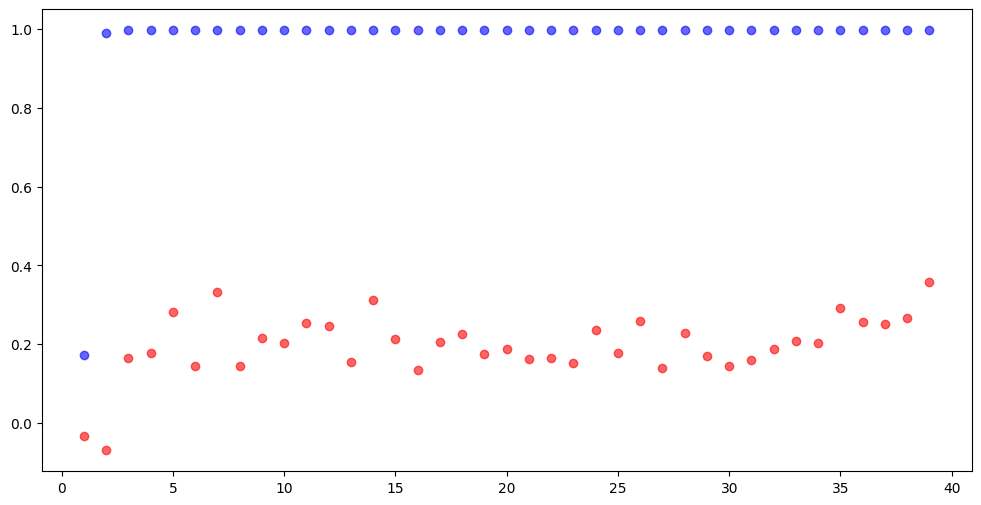

In [33]:
plt.figure(figsize=(12, 6))

plt.scatter(components, r2_train_scores, color='blue', label='Train', alpha=0.6)
plt.scatter(components, r2_test_scores, color='red', label='Train', alpha=0.6)
plt.scatter(best_pca, r2_train_scores[best_pca-1], color='black', s=100, label=f"Best_PCA = {best_pca}")
plt.scatter(best_pca, r2_test_scores[best_pca-1], color='black', s=100)

plt.ylim(-1,1)
plt.xlabel('Components PCA')
plt.ylabel('R2 Score')
plt.title('Comparació R2 score PCA')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Veamos las precisiones para el Best_PCA:
print(f'r2_train = {r2_train_scores[best_pca-1]}')
print(f'r2_test = {r2_test_scores[best_pca-1]}')

TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

Over-Fitting!!

Vamos a probar los siguientes modelos:
- XGBOOST
- Support Vector Regression
- Logistic Regression
- KNRegressor

Los siguientes Datasets:
- Dataset original normalizado con SS
- Datset original normalizado con log
- Dataset selected_features per a cada model

In [ ]:
from sklearn.feature_selection import SelectFromModel

def select_important_features(model, data, threshold='mean'):
    X_train, X_test, y_train, y_test = train_test_split(data[1], data[0], test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    if hasattr(model, 'feature_importances_'):
        selector = SelectFromModel(model, threshold=threshold, prefit=True)
        mask = selector.get_support()
    elif hasattr(model, 'coef_'):
        selector = SelectFromModel(model, threshold=threshold, prefit=True)
        mask = selector.get_support()
    else:
        print(f" --- El model {model.__class__.__name__} no suporta selecció de característiques. S'afageixen totes les variables---")
        mask = np.ones(X_norm.shape[1], dtype=bool)
    X_norm_selected = X_norm[:, mask] if isinstance(X_norm, np.ndarray) else X_norm.loc[:, mask]
    return X_norm_selected, mask

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

random_state = 50
regressors = {
    'XGB': XGBRegressor(random_state=random_state), 
    'SVR': SVR(),
    'Linear_Regression': LinearRegression(),
    'KN_Regressor': KNeighborsRegressor(),
    'GrandienBoosting_Regressor': GradientBoostingRegressor()
}
datasets = {
    'Original_SS': normalize_SS(df),
    'Original_log': normalize_log(df),
    'PCA2':
}

selected_data = {}
for n1, d in datasets.items():
    for n2, model in regressors.items():
        print(f"Seleccionant característiques importants dataset {n1} y model {n2}")
        X_selected, mask = select_important_features(model, d)
        selected_data[f'{n1}_{n2}'] = X_selected
        selected_data[f'{n1}_{n2}_mask'] = mask

Seleccionant característiques importants dataset Original_SS y model XGB
Seleccionant característiques importants dataset Original_SS y model SVR
 --- El model SVR no suporta selecció de característiques. S'afageixen totes les variables---
Seleccionant característiques importants dataset Original_SS y model Linear_Regression
Seleccionant característiques importants dataset Original_SS y model KN_Regressor
 --- El model KNeighborsRegressor no suporta selecció de característiques. S'afageixen totes les variables---
Seleccionant característiques importants dataset Original_SS y model GrandienBoosting_Regressor
Seleccionant característiques importants dataset Original_log y model XGB
Seleccionant característiques importants dataset Original_log y model SVR
 --- El model SVR no suporta selecció de característiques. S'afageixen totes les variables---
Seleccionant característiques importants dataset Original_log y model Linear_Regression
Seleccionant característiques importants dataset Origin

In [ ]:
test_size = 0.2
for n1 in datasets.keys():
    for n2 in regressors.keys():
        X_norm = selected_data[f'{n1}_{n2}']
        y = datasets[f'{n1}'][0]
        X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=test_size, random_state=random_state)

        model = regressors[f'{n2}']
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)

        print(f'Dataset {n1} i regressor {n2}: r2_train = {r2_train} i r2_test = {r2_test}')

Dataset Original_SS i regressor XGB: r2_train = 0.9834929395185839 i r2_test = 0.6468440506101949
Dataset Original_SS i regressor SVR: r2_train = 0.21101200254598818 i r2_test = 0.3752884898662432
Dataset Original_SS i regressor Linear_Regression: r2_train = 0.898637537645088 i r2_test = -1.6958426941393542e+25
Dataset Original_SS i regressor KN_Regressor: r2_train = 0.48569599637425054 i r2_test = 0.2728660646912018
Dataset Original_SS i regressor GrandienBoosting_Regressor: r2_train = 0.9790301428373026 i r2_test = 0.6627192902127546
Dataset Original_log i regressor XGB: r2_train = 0.8040194370813315 i r2_test = 0.5961893913011691
Dataset Original_log i regressor SVR: r2_train = 0.6592757163257827 i r2_test = 0.46286625788982827
Dataset Original_log i regressor Linear_Regression: r2_train = 0.701516957172023 i r2_test = -8.729257898070739e+26
Dataset Original_log i regressor KN_Regressor: r2_train = 0.610280205358978 i r2_test = 0.4708638987547251
Dataset Original_log i regressor Gra

Anem a buscar una cerca d'hiperparametres per a cada model i aixi millorar les prediccion:

In [ ]:
xgb_param_grid = {'min_child_weight': [1, 5, 10],
                  'gamma': [0.5, 1, 1.5, 2, 5],
                  'subsample': [0.6, 0.8, 1.0],
                  'colsample_bytree': [0.6, 0.8, 1.0],
                  'max_depth': [3, 4, 5]}
svr_param_grid = {'C': [1, 10, 12, 14, 16],
                  'gamma': [0.001, 0.01, 0.1],
                  'epsilon': [0.001, 0.01, 0.1],
                  'kernel': ["linear", "poly", "rbf", "sigmoid"]}
lr_param_grid = {'fit_intercept': [True, False],
                 'positive': [True, False]}
kn_param_grid = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
                 'weights': ['uniform','distance'],
                 'p':[1,2,5]}
gr_param_grid = {'learning_rate': [0.01, 0.1, 0.2],
                 'n_estimators': [100, 200, 300],
                 'max_depth': [3, 5, 7]}

params_grid = {'XGB':xgb_param_grid,
               'SVR':svr_param_grid,
               'Linear_Regression':lr_param_grid,
               'KN_Regressor':kn_param_grid,
               'GrandienBoosting_Regressor':gr_param_grid}

HYPERPARAMETRES SEARCH

In [ ]:
test_size = 0.2
for n1 in datasets.keys():
    for n2 in regressors.keys():
        X_norm = selected_data[f'{n1}_{n2}']
        y = datasets[f'{n1}'][0]
        model = regressors[f'{n2}']
        print(f'Dataset {n1} i regressor {n2}:')
        best_params = hyperparameters_search(model, params_grid[f'{n2}'], X_norm, y)

Dataset Original_SS i regressor XGB:
r2_train = 0.9750031146140555 r2_test = 0.6650158455157604
Dataset Original_SS i regressor SVR:
